<a href="https://colab.research.google.com/github/plue1011/ObjectDetection/blob/master/SSD_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [183]:
!nvidia-smi

Tue May  5 04:16:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    50W / 250W |  14347MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# パッケージのimport
from math import sqrt
from itertools import product
import cv2
import time
import glob

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optimizers
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [126]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!tar -zxf /content/drive/My\ Drive/study/CNN/dataset/RoadDamageDataset.tar.gz

# 学習(動作確認)

In [0]:
# 自作モジュール
# google colobでモジュール読み込みのために必要
import sys
sys.path.append("/content/drive/My Drive/study/CNN/Object_Detection/utils")

from make_network import SSD
from make_network import MultiBoxLoss

from path2dataloader import make_data_path_list
from path2dataloader import Anno_xml2list
from path2dataloader import DataTransform
from path2dataloader import DamageDataset
from path2dataloader import od_collate_fn

from ssd_predict_show import SSDPredictShow

## データ準備

In [0]:
train_img_path_list_prime = []
train_anno_path_list_prime = []
val_img_path_list_prime = []
val_anno_path_list_prime = []

for root_path in glob.glob("/content/RoadDamageDataset/*"):
    train_img_path_list_part, train_anno_path_list_part = make_data_path_list(root_path+"/", "train")
    train_img_path_list_prime += train_img_path_list_part
    train_anno_path_list_prime += train_anno_path_list_part

    val_img_path_list_part, val_anno_path_list_part = make_data_path_list(root_path+"/", "val")
    val_img_path_list_prime += val_img_path_list_part
    val_anno_path_list_prime += val_anno_path_list_part

In [204]:
val_img_path_list

['/content/RoadDamageDataset/Nagakute/JPEGImages/Nagakute_20170907155039.jpg',
 '/content/RoadDamageDataset/Nagakute/JPEGImages/Nagakute_20170912140422.jpg',
 '/content/RoadDamageDataset/Nagakute/JPEGImages/Nagakute_20170907151544.jpg',
 '/content/RoadDamageDataset/Nagakute/JPEGImages/Nagakute_20170912135851.jpg',
 '/content/RoadDamageDataset/Nagakute/JPEGImages/Nagakute_20170908101153.jpg',
 '/content/RoadDamageDataset/Nagakute/JPEGImages/Nagakute_20170908111743.jpg',
 '/content/RoadDamageDataset/Nagakute/JPEGImages/Nagakute_20170912135431.jpg',
 '/content/RoadDamageDataset/Nagakute/JPEGImages/Nagakute_20170907151808.jpg',
 '/content/RoadDamageDataset/Nagakute/JPEGImages/Nagakute_20170908101235.jpg',
 '/content/RoadDamageDataset/Nagakute/JPEGImages/Nagakute_20170907161940.jpg',
 '/content/RoadDamageDataset/Nagakute/JPEGImages/Nagakute_20170908090213.jpg',
 '/content/RoadDamageDataset/Nagakute/JPEGImages/Nagakute_20170907144515.jpg',
 '/content/RoadDamageDataset/Nagakute/JPEGImages/Nag

In [193]:
len(train_img_path_list_prime), len(train_anno_path_list_prime), len(val_img_path_list_prime), len(val_anno_path_list_prime)

(7240, 7240, 1813, 1813)

アノテーションが存在しない画像を削除する

In [0]:
# ひびの割れ方のクラス
damage_class = ["D00", "D01", "D10", "D11", "D20", "D40", "D43", "D44", "D30"]
transform_anno = Anno_xml2list(damage_class)

train_img_path_list = []
train_anno_path_list = []
val_img_path_list = []
val_anno_path_list = []

for i in range(len(train_anno_path_list_prime)):
    anno_list = transform_anno(train_anno_path_list_prime[i], 1, 1)

    if len(anno_list) > 0:
        train_img_path_list.append(train_img_path_list_prime[i])
        train_anno_path_list.append(train_anno_path_list_prime[i])

for i in range(len(val_anno_path_list_prime)):
    anno_list = transform_anno(val_anno_path_list_prime[i], 1, 1)

    if len(anno_list) > 0:
        val_img_path_list.append(val_img_path_list_prime[i])
        val_anno_path_list.append(val_anno_path_list_prime[i])

In [195]:
len(train_img_path_list), len(train_anno_path_list), len(val_img_path_list), len(val_anno_path_list) 

(7239, 7239, 1813, 1813)

In [0]:
# 画像のinputサイズを300×300にする
input_size = 300

train_dataset = DamageDataset(train_img_path_list, train_anno_path_list, transform=DataTransform(input_size), transform_anno=Anno_xml2list(damage_class))
val_dataset = DamageDataset(val_img_path_list, val_anno_path_list, transform=DataTransform(input_size), transform_anno=Anno_xml2list(damage_class))

In [0]:
# DataLoaderの作成
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

In [0]:
# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

## モデル作成

In [199]:
# SSD300の設定
ssd_cfg = {
    "num_classes": 8,
    "input_size": 300,  # 画像の入力サイズ
    "bbox_aspect_num": [4, 6, 6, 6, 4, 4],  # 出力するDboxのアスペクト比の種類
    "feature_maps": [38, 19, 10, 5, 3, 1], # 各sourceの画像サイズ
    "s_min": 0.2,
    "s_max":0.9,
    "aspect_ratios":[1, 2, 1/2, 3, 1/3]  # 順番重要(bbox_aspect_numが4種類の時に前から4つである1, 2, 1/2をして欲しいため)
}

# GPUが使えるかを確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

# SSDネットワークモデル
net = SSD(phase="train", cfg=ssd_cfg)

# SSDの初期の重みを設定
# ssdのvgg部分に重みをロードする
vgg_weights = torch.load("/content/drive/My Drive/study/CNN/weights/vgg16_reducedfc.pth")
net.vgg.load_state_dict(vgg_weights)

# ssdのその他のネットワークの重みはHeの初期値で初期化
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:  # バイアス項がある場合
            nn.init.constant_(m.bias, 0.0)

# Heの初期値を適用
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

print('ネットワーク設定完了：学習済みの重みをロードしました')

使用デバイス： cuda:0
ネットワーク設定完了：学習済みの重みをロードしました


In [0]:
# 損失関数の設定
criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos=3, device=device)

# 最適化手法の設定
optimizer = optimizers.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

## 学習

In [0]:
# モデルを学習させる関数を作成

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # イテレーションカウンタをセット
    iteration = 1
    epoch_train_loss = 0.0  # epochの損失和
    epoch_val_loss = 0.0  # epochの損失和
    logs = []

    # epochのループ
    for epoch in range(num_epochs+1):

        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                print('（train）')
            else:
                if((epoch+1) % 10 == 0):
                    net.eval()   # モデルを検証モードに
                    print('-------------')
                    print('（val）')
                else:
                    # 検証は10回に1回だけ行う
                    continue

            # データローダーからminibatchずつ取り出すループ
            for images, targets in dataloaders_dict[phase]:

                # GPUが使えるならGPUにデータを送る
                images = images.to(device)
                targets = [ann.to(device)
                           for ann in targets]  # リストの各要素のテンソルをGPUへ

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    # 順伝搬（forward）計算
                    outputs = net(images)

                    # 損失の計算
                    loss_l, loss_c = criterion(outputs, targets)
                    loss = loss_l + loss_c

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()  # 勾配の計算

                        # 勾配が大きくなりすぎると計算が不安定になるので、clipで最大でも勾配2.0に留める
                        nn.utils.clip_grad_value_(
                            net.parameters(), clip_value=2.0)

                        optimizer.step()  # パラメータ更新

                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item(), duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item()
                        iteration += 1

                    # 検証時
                    else:
                        epoch_val_loss += loss.item()

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss, epoch_val_loss))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        # ログを保存
        log_epoch = {'epoch': epoch+1, 'train_loss': epoch_train_loss, 'val_loss': epoch_val_loss}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("/content/drive/My Drive/study/CNN/Object_Detection/log_output.csv")

        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和

        # ネットワークを保存する
        if ((epoch+1) % 50 == 0):
            torch.save(net.state_dict(), '/content/drive/My Drive/study/CNN/weights/ssd300_' + str(epoch+1) + '.pth')

In [0]:
# 学習・検証を実行する
num_epochs= 300
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

# 推論

In [22]:
# 動作の確認

# SSD300の設定
ssd_cfg = {
    "num_classes": 8,
    "input_size": 300,  # 画像の入力サイズ
    "bbox_aspect_num": [4, 6, 6, 6, 4, 4],  # 出力するDboxのアスペクト比の種類
    "feature_maps": [38, 19, 10, 5, 3, 1], # 各sourceの画像サイズ
    "s_min": 0.2,
    "s_max":0.9,
    "aspect_ratios":[1, 2, 1/2, 3, 1/3]  # 順番重要(bbox_aspect_numが4種類の時に前から4つである1, 2, 1/2をして欲しいため)
}

model = SSD("inference", ssd_cfg)

# 本番は学習させたモデルを読み込むが今はとりあえず初期値で
net_weights = torch.load("/content/drive/My Drive/study/CNN/weights/ssd300_1.pth", map_location={"cuda:0": "cpu"})
model.load_state_dict(net_weights)

<All keys matched successfully>

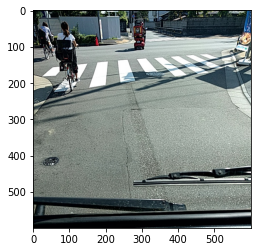

In [23]:
image_file_path = "/content/RoadDamageDataset/Adachi/JPEGImages/Adachi_20170908142224.jpg"
img = cv2.imread(image_file_path)
height, width, channels = img.shape

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [0]:
input_size = 300
transform = DataTransform(input_size)
phase = "val"
img_transformed, boxes, labels = transform(img, "", "")
img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

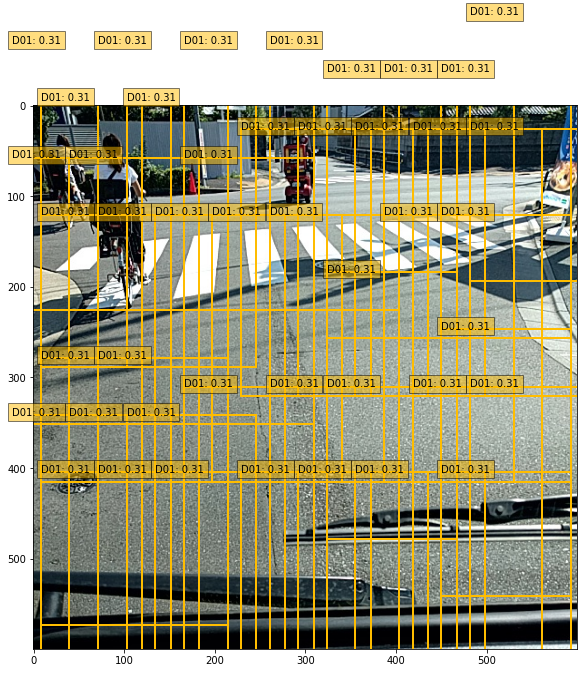

In [26]:
model.eval()
x = img.unsqueeze(0)

detections = model(x)

# ひびの割れ方のクラス
damage_class=["D00", "D01", "D10", "D11", "D20", "D40", "D43", "D44", "30"]

ssd = SSDPredictShow(eval_categories=damage_class, net=model)
ssd.show(image_file_path, data_confidence_level=0.3)